### YOLOv5

* [Roboflow Colab](https://colab.research.google.com/drive/1gDZ2xcTOgR39tGGs-EZ6i3RTs16wmzZQ)
* [YOLOv5 Train Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
* [Sahu's Google Colab](https://colab.research.google.com/drive/16QCaYzTuHCOF9CQLQYmGNxmtY1xKAIdn?usp=sharing)
* [Sahu's blog on YOLOv5](https://medium.com/analytics-vidhya/training-a-custom-object-detection-model-with-yolo-v5-aa9974c07088)

In [1]:
%cd /root/
# clone repo
!git clone https://github.com/ultralytics/yolov5.git yolo
%cd yolo
!pip install -U -r requirements.txt  # install dependencies

/root
fatal: destination path 'yolo' already exists and is not an empty directory.
/root/yolo


In [2]:
import torch
from IPython.display import Image  # for displaying images
# from utils.google_utils import gdrive_download  # for downloading models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# NOTE: For downloading dataset in YOLOv5 format only
%cd /root
#!curl -L "https://app.roboflow.com/ds/BdMU5DUolE?key=rML7FNk3mb" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)
/root


In [3]:
!cat yolo/data.yaml

train: ../data2/train/images
val: ../data2/valid/images
test: ../data2/test/images

nc: 4
names: ['0', '1', '2', '3']

In [4]:
# def num of classes
import yaml
with open("yolo/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'4'

In [5]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [6]:
%%writetemplate /root/yolo/models/custom_yolov5s.yaml
# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [ ]:
%%time
!rm -rf /root/yolo/runs/train/yolov5s_results/
%cd /root/yolo/
!python train.py --workers 1 --img 416 --batch 32 --epochs 100 --data './data.yaml' --cfg /root/yolo/models/custom_yolov5s.yaml --weights '/root/yolo/best.pt' --name yolov5s_results
# weights at: /root/yolov5/runs/train/yolov5s_results10/weights/best.pt
!cp /root/yolo/runs/train/yolov5s_results/weights/best.pt /root/yolo/

See predicted results at:
* /yolo/runs/train/yolov5s_results/test_*

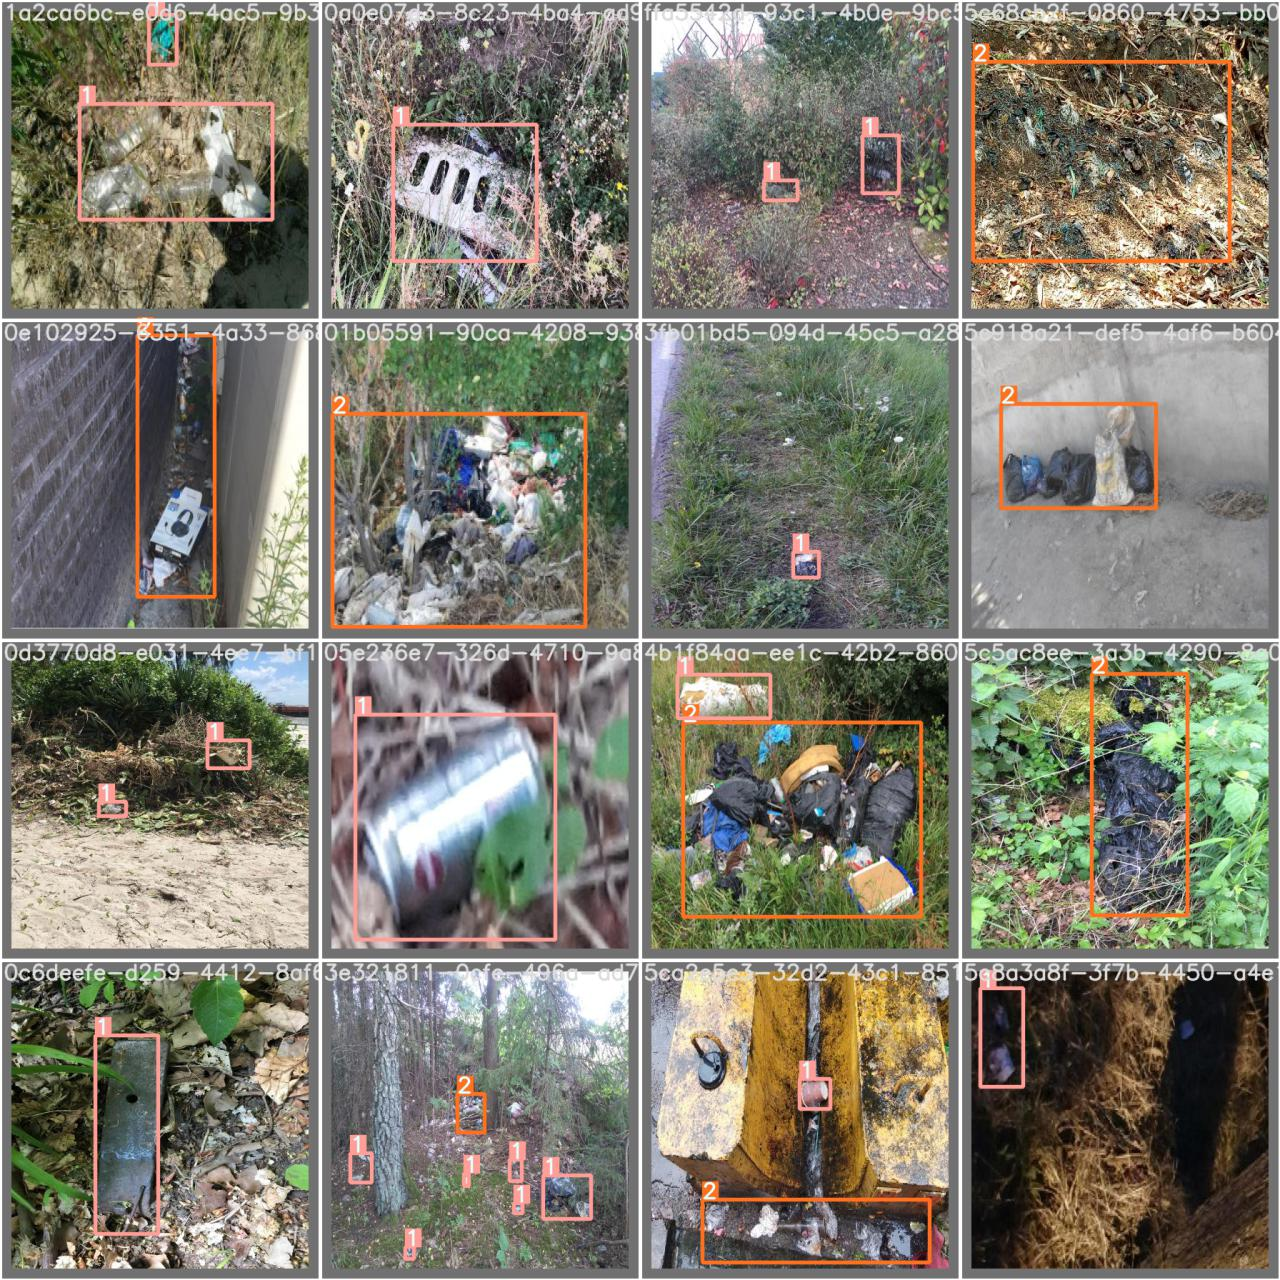

In [15]:
# What we labeled
Image(filename='/root/yolo/runs/train/yolov5s_results/test_batch1_labels.jpg', width=900)

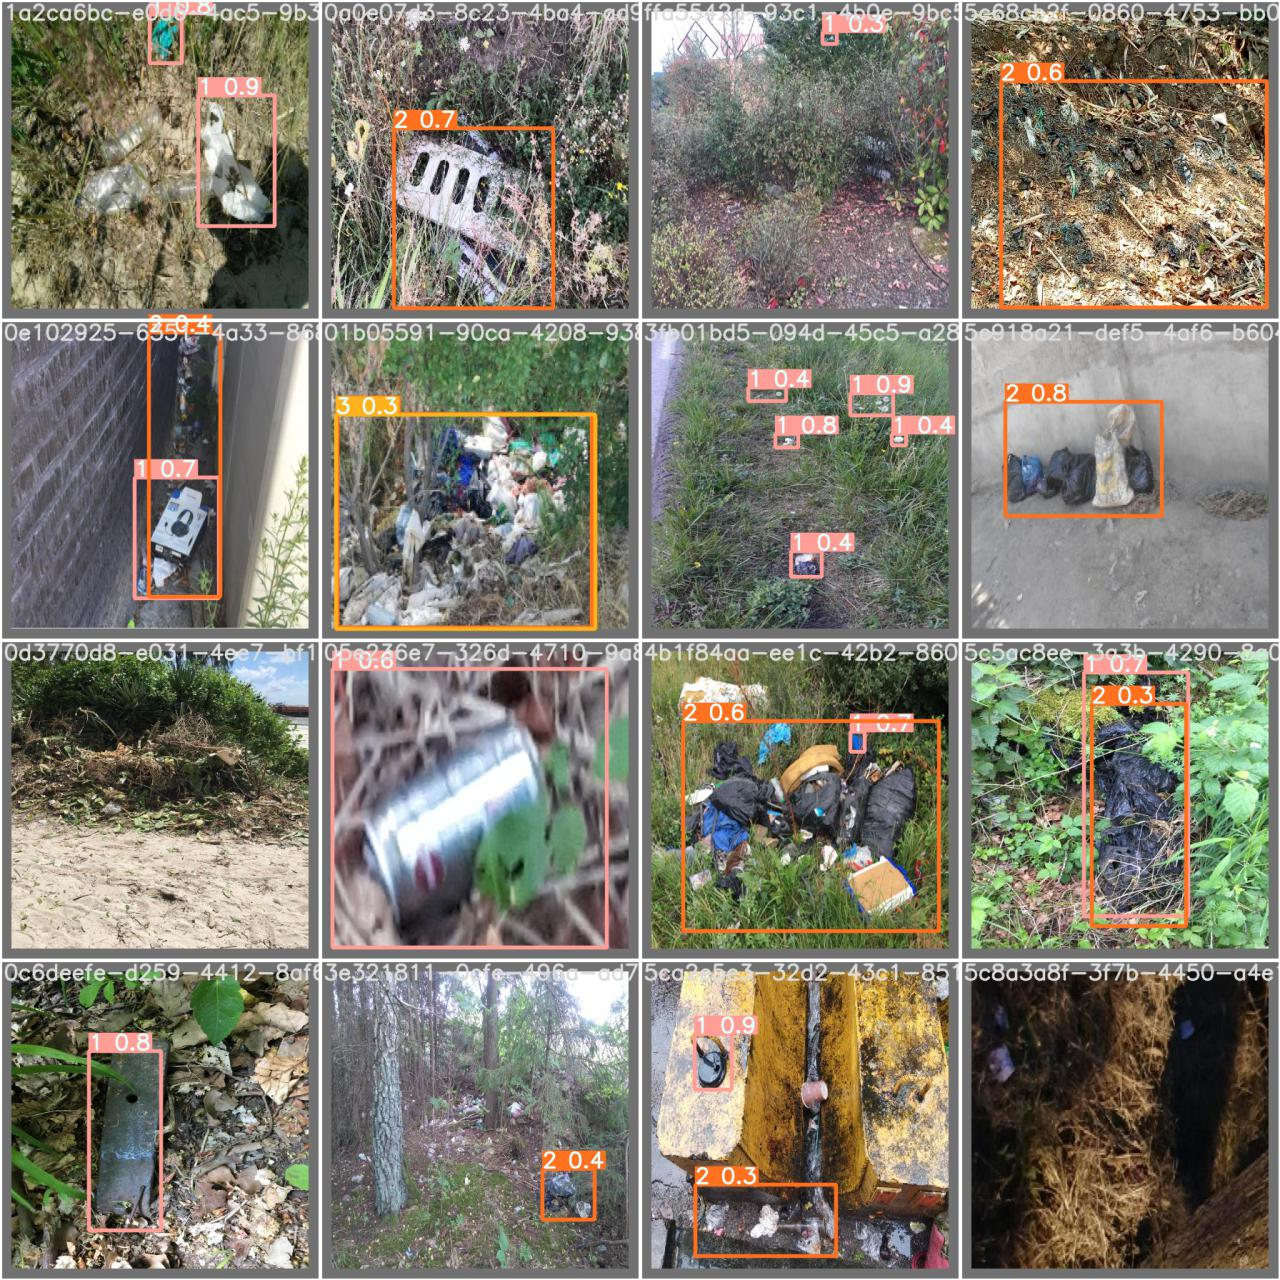

In [17]:
# what YOLOv5 predicted
Image(filename='/root/yolo/runs/train/yolov5s_results/test_batch1_pred.jpg', width=900)

In [2]:
%cd /root/yolo/
#!python detect.py --source '/root/test/images/' --weights /root/yolo/best.pt
!python test.py --data data.yaml --weights /root/yolo/best.pt --img 416 --iou 0.4 --task test
# Results saved to runs/detect/exp

/root/yolo
Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data.yaml', device='', exist_ok=False, half=False, imgsz=416, iou_thres=0.4, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['/root/yolo/best.pt'])
YOLOv5 🚀 v5.0-192-g30e4c4f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 476 layers, 87218881 parameters, 0 gradients, 217.2 GFLOPs
test: Scanning '../data2/test/labels.cache' images and labels... 98 found, 0 mis
               

* Getting results for a single image for production: https://towardsai.net/p/computer-vision/yolo-v5-object-detection-on-a-custom-dataset

In [3]:
!python test.py --data data.yaml --weights /root/yolo/best.pt --img 416 --iou 0.45 --task test

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data.yaml', device='', exist_ok=False, half=False, imgsz=416, iou_thres=0.45, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['/root/yolo/best.pt'])
YOLOv5 🚀 v5.0-192-g30e4c4f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 476 layers, 87218881 parameters, 0 gradients, 217.2 GFLOPs
test: Scanning '../data2/test/labels.cache' images and labels... 98 found, 0 mis
               Class     

In [29]:
%cd /root/yolo/
!python detect.py --source '/root/data2/test/images/' --img-size 416 --weights /root/yolo/best.pt

/root/yolo
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, imgsz=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='/root/data2/test/images/', update=False, view_img=False, weights=['/root/yolo/best.pt'])
YOLOv5 🚀 v5.0-192-g30e4c4f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 476 layers, 87218881 parameters, 0 gradients, 217.2 GFLOPs
image 1/98 

## [Link to How to label data in YOLOv5](https://github.com/ultralytics/yolov5/issues/2844#issuecomment-851338384)